In [1]:
import time
import os
import torchvision.models as models
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch.utils.model_zoo as model_zoo
import cv2
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from PIL import Image
from collections import OrderedDict
from PIL import Image
# import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms
from PIL import Image, ImageOps
from torch.autograd import Variable
from torchvision.utils import make_grid
import numpy as np

import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def load_image(img_path, to_array=False, to_variable=False):
    img = Image.open(img_path).convert("RGB")
    img = ImageOps.fit(img, (224,224), Image.ANTIALIAS)

    scale = transforms.Scale((224,224))
    tensorize = transforms.ToTensor()
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    loader = transforms.Compose([
        scale, tensorize, normalize
    ])
    img_tensor = loader(img)

    if to_array:
        img_tensor = img_tensor.unsqueeze(0)
    if to_variable:
        img_tensor = Variable(img_tensor)

    return img_tensor

In [78]:
class FeatureExtractor(nn.Sequential):
    def __init__(self):
        super(FeatureExtractor, self).__init__()

    def add_layer(self, name, layer):
        self.add_module(name, layer)

    def forward(self, x):
        list = []
        for module in self._modules:
            x = self._modules[module](x)
            list.append(x)
        return x


class VGG19:
    def __init__(self,use_cuda=True):
        self.cnn_temp = models.vgg19(pretrained=True).features
        self.model = FeatureExtractor()  # the new Feature extractor module network
        conv_counter = 1
        relu_counter = 1
        batn_counter = 1

        block_counter = 1
        self.use_cuda = use_cuda

        for i, layer in enumerate(list(self.cnn_temp)[:-1]):

            if isinstance(layer, nn.Conv2d):
                name = "conv_" + str(block_counter) + "_" + str(conv_counter) + "__" + str(i)
                conv_counter += 1
                self.model.add_layer(name, layer)

            if isinstance(layer, nn.ReLU):
                name = "relu_" + str(block_counter) + "_" + str(relu_counter) + "__" + str(i)
                relu_counter += 1
                self.model.add_layer(name, nn.ReLU(inplace=False))

            if isinstance(layer, nn.MaxPool2d):
                name = "pool_" + str(block_counter) + "__" + str(i)
                batn_counter = relu_counter = conv_counter = 1
                block_counter += 1
                self.model.add_layer(name, nn.AvgPool2d((2,2)))  # ***


            if isinstance(layer, nn.BatchNorm2d):
                name = "batn_" + str(block_counter) + "_" + str(batn_counter) + "__" + str(i)
                batn_counter += 1
                self.model.add_layer(name, layer)  # ***
        
        self.model.add_layer("deconv_1",nn.Conv2d(512,512,3,padding=1))
        self.model.add_layer("relu_1",nn.ReLU())
        self.model.add_layer("unpool_1",nn.MaxUnpool2d(2,stride=2))
        
#         self.model.add_layer("deconv_2",nn.Conv2d(512,256,3,padding=1))
#         self.model.add_layer("relu_2",nn.ReLU())
#         self.model.add_layer("unpool_2",nn.Upsample(scale_factor=2))
        
#         self.model.add_layer("deconv_3",nn.Conv2d(256,128,3,padding=1))
#         self.model.add_layer("relu_3",nn.ReLU())
#         self.model.add_layer("unpool_3",nn.Upsample(scale_factor=2))
        
#         self.model.add_layer("deconv_4",nn.Conv2d(128,64,3,padding=1))
#         self.model.add_layer("relu_4",nn.ReLU())
#         self.model.add_layer("unpool_4",nn.Upsample(scale_factor=2))
        
#         self.model.add_layer("deconv_5",nn.Conv2d(64,3,3,padding=1))
#         self.model.add_layer("relu_5",nn.Tanh())

        
#         self.model.add_layer("deconv_2",nn.ConvTranspose2d(512,256,3,padding=1,stride=2,output_padding=1))
#         self.model.add_layer("relu_2",nn.ReLU())
        
#         self.model.add_layer("deconv_3",nn.ConvTranspose2d(256,128,3,padding=1,stride=2,output_padding=1))
#         self.model.add_layer("relu_3",nn.ReLU())
        
#         self.model.add_layer("deconv_4",nn.ConvTranspose2d(128,64,3,padding=1,stride=2,output_padding=1))
#         self.model.add_layer("relu_4",nn.ReLU())
        
#         self.model.add_layer("deconv_5",nn.ConvTranspose2d(64,3,3,padding=1,stride=1))
#         self.model.add_layer("relu_5",nn.Tanh())
        
        if use_cuda:
            self.model.cuda()
    

In [79]:
m = VGG19()

In [80]:
m.model

FeatureExtractor (
  (conv_1_1__0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1_1__1): ReLU ()
  (conv_1_2__2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1_2__3): ReLU ()
  (pool_1__4): AvgPool2d (size=(2, 2), stride=(2, 2), padding=0, ceil_mode=False, count_include_pad=True)
  (conv_2_1__5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2_1__6): ReLU ()
  (conv_2_2__7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2_2__8): ReLU ()
  (pool_2__9): AvgPool2d (size=(2, 2), stride=(2, 2), padding=0, ceil_mode=False, count_include_pad=True)
  (conv_3_1__10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3_1__11): ReLU ()
  (conv_3_2__12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3_2__13): ReLU ()
  (conv_3_3__14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3_3__15): ReLU ()

In [81]:
img = load_image('../data/raw/mona.png',to_array=True,to_variable=True).cuda()

In [82]:
img

Variable containing:
( 0 , 0 ,.,.) = 
  0.6563  0.8447  0.8276  ...   0.7933  1.9749  2.2489
  0.7248  0.7762  0.8104  ...   0.8276  1.9749  2.2489
  0.8104  0.8447  0.7077  ...   0.8789  1.9920  2.2489
           ...             ⋱             ...          
 -0.1999 -0.2684 -0.3027  ...  -1.3130  1.5982  2.2489
  1.9235  1.9064  1.8893  ...   1.7694  2.1633  2.2489
  2.2489  2.2489  2.2489  ...   2.2489  2.2489  2.2489

( 0 , 1 ,.,.) = 
  0.3277  0.5028  0.4503  ...   0.2227  2.0259  2.4286
  0.3803  0.4328  0.4153  ...   0.2752  2.0259  2.4286
  0.4853  0.5203  0.3452  ...   0.3627  2.0259  2.4286
           ...             ⋱             ...          
 -0.3550 -0.4251 -0.4426  ...  -1.3880  1.7283  2.4286
  2.0434  2.0434  2.0434  ...   1.9034  2.3410  2.4286
  2.4286  2.4286  2.4286  ...   2.4286  2.4286  2.4286

( 0 , 2 ,.,.) = 
 -0.7587 -0.5844 -0.6367  ...  -0.7064  2.0125  2.6400
 -0.7413 -0.6890 -0.6890  ...  -0.7238  2.0125  2.6400
 -0.7064 -0.6715 -0.8284  ...  -0.7238  2.0125

In [83]:
t = m.model(img)

TypeError: forward() missing 1 required positional argument: 'indices'

In [ ]:
t

In [57]:
optimizer = optim.Adam(m.model.parameters())

In [58]:
loss  = nn.MSELoss(size_average=True)

In [59]:
for i in range(20):
    output = m.model(img)
    loss_val = loss(output,img)
    loss_val.backward()
    optimizer.step()
    print(loss_val.data.cpu().numpy())
    

[ 1.86759734]
[ 1.51938272]
[ 1.67221475]
[ 1.67219377]
[ 1.67219377]
[ 1.67219377]
[ 1.67219377]
[ 1.67219377]
[ 1.67219377]
[ 1.67219377]
[ 1.67219377]
[ 1.67219377]
[ 1.67219377]
[ 1.67219377]
[ 1.67219377]
[ 1.67219377]
[ 1.67219377]
[ 1.67219377]
[ 1.67219377]
[ 1.67219377]


In [60]:
t = m.model(img).data.cpu().squeeze().numpy()

In [71]:
t.shape

(3, 224, 224)

In [61]:
np.unique(t)

array([-1.,  1.], dtype=float32)

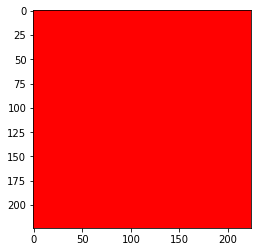

In [75]:
plt.imshow(t.transpose(1,2,0))

In [63]:
t.squeeze().numpy().transpose(1,2,0).shape

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [ ]:
np.unique(img.data.cpu().numpy())

In [77]:
np.unique(img.data.cpu().numpy())

array([-2.03571415, -2.01820731, -2.00070024, -1.99803066, -1.98319328,
       -1.9656862 , -1.96378124, -1.94817924, -1.94665647, -1.93067217,
       -1.92953169, -1.91316521, -1.91240692, -1.89565825, -1.87815738,
       -1.87815118, -1.86103272, -1.86064422, -1.84390795, -1.84313726,
       -1.82678318, -1.82563019, -1.80965841, -1.80812323, -1.80444443,
       -1.79253364, -1.79061615, -1.7870152 , -1.77540886, -1.7731092 ,
       -1.76958609, -1.75828421, -1.75560224, -1.75215685, -1.74115944,
       -1.73809516, -1.73472762, -1.72403467, -1.72058821, -1.71729851,
       -1.70690989, -1.70308125, -1.69986928, -1.68978512, -1.68557417,
       -1.68244004, -1.67266035, -1.66806722, -1.66501093, -1.6555357 ,
       -1.65056014, -1.6475817 , -1.63841093, -1.63305318, -1.63015246,
       -1.62128615, -1.61554623, -1.61272335, -1.60416138, -1.59803915,
       -1.59529412, -1.58703661, -1.58053219, -1.57786489, -1.56991184,
       -1.56302524, -1.56043577, -1.55278718, -1.54551816, -1.54